/tmp/ipython-input-3-4026056394.py:34: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_stations_od = pd.unique(list(origin_stations) + list(destination_columns))


English visualization for PM Peak data with larger legend has been created and saved as 'network_graph_pm_peak.png'.


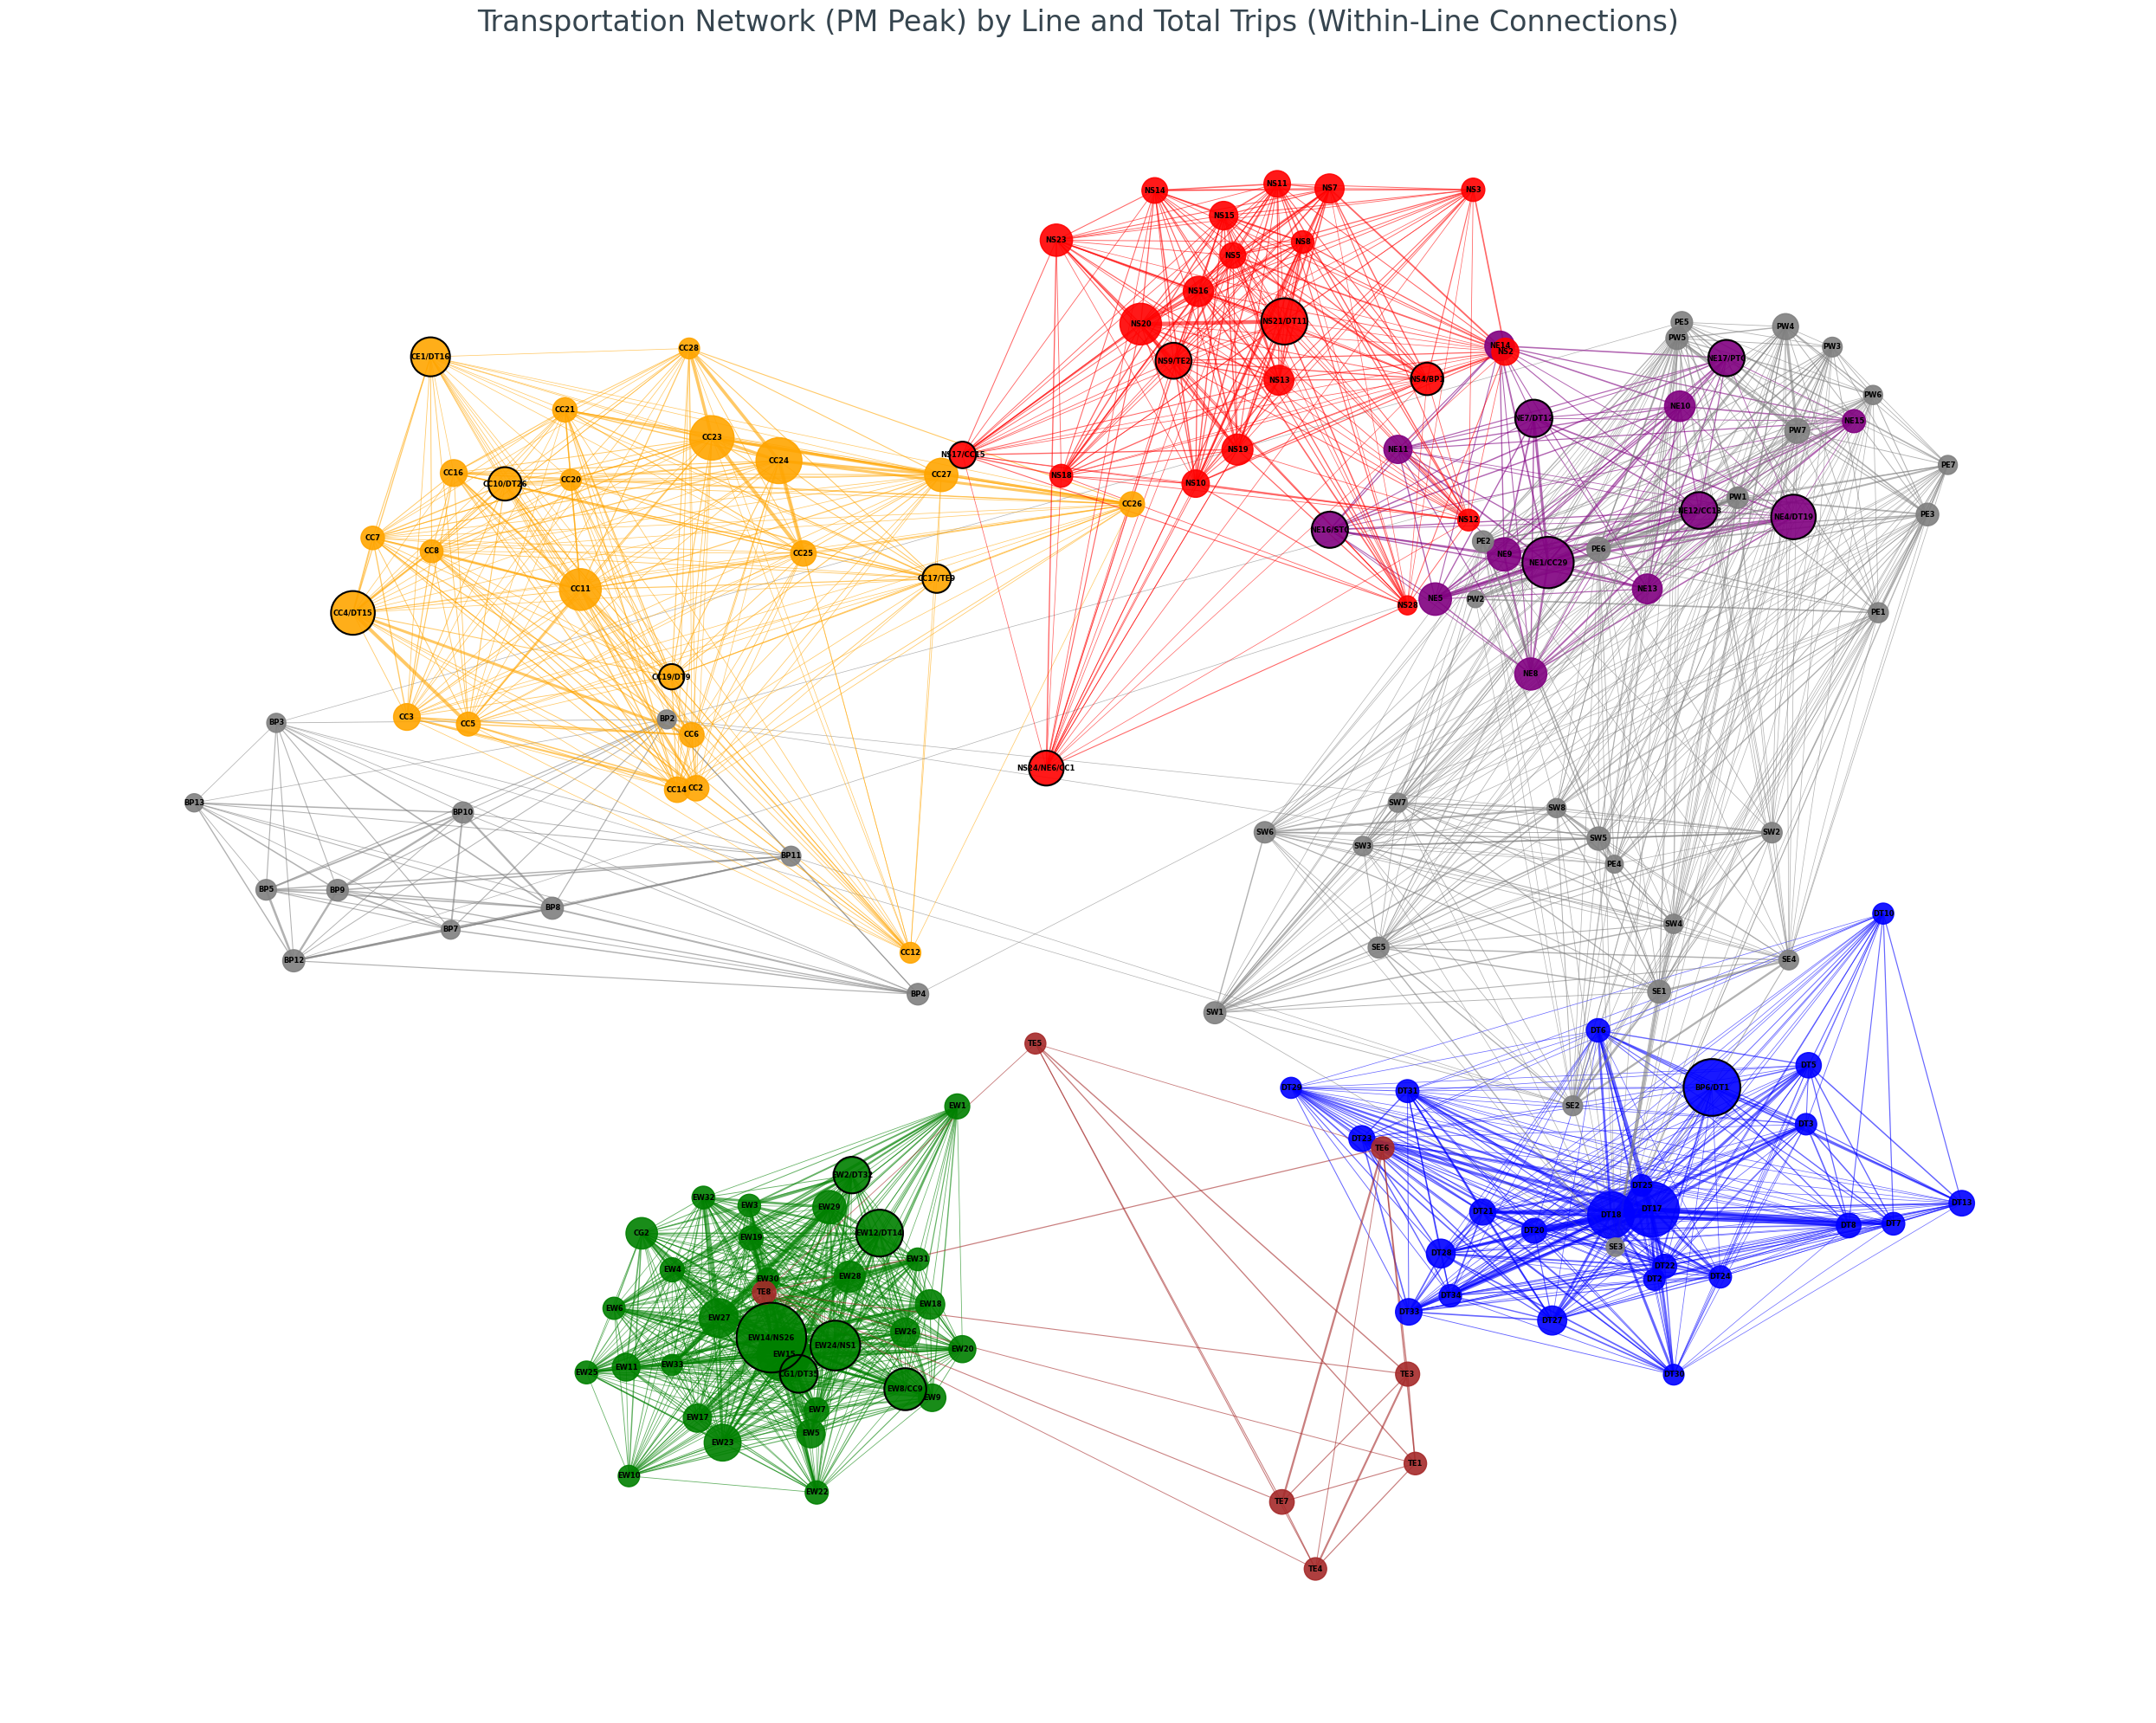

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# Load the OD data
df_od = pd.read_csv('od_am_peak.csv')
# df_od = pd.read_csv('od_pm_peak.csv')

# Load the MRT line data from mrtt.csv (this file remains the same)
df_mrtt = pd.read_csv('mrt.csv')

# Create a mapping from STN_NO to COLOR and STN_NAME using mrtt.csv
station_info_map = df_mrtt.set_index('STN_NO').to_dict(orient='index')

# Define the line name mapping for the legend (this also remains the same)
line_name_mapping = {
    'GREEN': 'East-West Line',
    'RED': 'North-South Line',
    'Purple': 'North-East Line',
    'ORANGE': 'Circle Line',
    'BLUE': 'Downtown Line',
    'BROWN': 'Thomson-East Coast Line',
    'PINK': 'Thomson-East Coast Line',
    'GRAY': 'LRT Line'
}

# --- Data Preparation for NetworkX ---

# 1. Identify all unique station names from OD data
origin_stations = df_od['ORIGIN_PT_CODE'].unique()
destination_columns = df_od.columns.drop('ORIGIN_PT_CODE').unique()
all_stations_od = pd.unique(list(origin_stations) + list(destination_columns))

# Filter stations to only include those with line information from df_mrtt
all_stations_with_info = [s for s in all_stations_od if s in station_info_map]

# 2. Calculate total trips for each station using the new OD data
station_total_trips = {station: 0 for station in all_stations_with_info}

for index, row in df_od.iterrows():
    origin = row['ORIGIN_PT_CODE']
    for dest_col in destination_columns:
        trips = row[dest_col]
        if trips > 0:
            if origin in station_total_trips:
                station_total_trips[origin] += trips
            if dest_col in station_total_trips:
                station_total_trips[dest_col] += trips

# 3. Identify transit stations based on '/' in name
transit_stations_by_name = {station for station in all_stations_with_info if '/' in station}

# 4. Create a NetworkX graph
G = nx.Graph()

# Add nodes with attributes (total_trips, is_transit, line_color)
node_colors_used = set()

for station in all_stations_with_info:
    is_transit = station in transit_stations_by_name
    total_trips = station_total_trips.get(station, 0)
    line_color_raw = station_info_map[station]['COLOR'] if station in station_info_map else 'grey'
    line_color = line_color_raw.lower()

    G.add_node(station, is_transit=is_transit, total_trips=total_trips, line_color=line_color)
    node_colors_used.add(line_color_raw)

# Add edges with attributes, but only if origin and destination are on the same line
for index, row in df_od.iterrows():
    origin = row['ORIGIN_PT_CODE']
    for dest_col in destination_columns:
        trips = row[dest_col]
        if trips > 0:
            if origin in G.nodes and dest_col in G.nodes:
                origin_line_color = G.nodes[origin]['line_color']
                dest_line_color = G.nodes[dest_col]['line_color']

                if origin_line_color == dest_line_color:
                    G.add_edge(origin, dest_col, weight=trips)

# --- Visualization ---

plt.figure(figsize=(25, 20))
pos = nx.spring_layout(G, k=0.3, iterations=100, seed=42)

# Node sizes and colors
node_sizes = [G.nodes[node]['total_trips'] for node in G.nodes()]
max_trips = max(node_sizes) if node_sizes else 1
min_trips = min(node_sizes) if node_sizes else 0
if max_trips == min_trips:
    scaled_node_sizes = [200 for _ in G.nodes()]
else:
    scaled_node_sizes = [200 + (val - min_trips) / (max_trips - min_trips) * 3000 for val in node_sizes]

node_fill_colors = [G.nodes[node]['line_color'] for node in G.nodes()]

# Edge widths and colors
existing_edges = list(G.edges(data=True))
edge_weights = [d['weight'] for u, v, d in existing_edges]

max_edge_weight = max(edge_weights) if edge_weights else 1
min_edge_weight = min(edge_weights) if edge_weights else 0

if max_edge_weight == min_edge_weight:
    scaled_edge_widths = [0.5 for _ in existing_edges]
else:
    scaled_edge_widths = [0.5 + (val - min_edge_weight) / (max_edge_weight - min_edge_weight) * 5 for val in edge_weights]

edge_colors_by_line = []
for u, v, data in existing_edges:
    edge_colors_by_line.append(G.nodes[u]['line_color'])

# Draw nodes (filled circle)
nx.draw_networkx_nodes(G, pos, node_size=scaled_node_sizes, node_color=node_fill_colors, alpha=0.9)

# Draw transit station borders
transit_nodes = [node for node in G.nodes() if G.nodes[node]['is_transit']]
if transit_nodes:
    transit_node_scaled_sizes = [scaled_node_sizes[list(G.nodes()).index(n)] for n in transit_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=transit_nodes, node_size=np.array(transit_node_scaled_sizes) * 1.05,
                           node_color='none', edgecolors='black', linewidths=1.5)

# Draw edges with dynamic colors
nx.draw_networkx_edges(G, pos, edgelist=existing_edges, width=scaled_edge_widths, alpha=0.6, edge_color=edge_colors_by_line)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold', font_color='black')


# --- Custom Legend (English) ---
# legend_elements = []

# for color_code in sorted(list(node_colors_used)):
#     line_full_name = line_name_mapping.get(color_code, f'Line {color_code.capitalize()}')
#     legend_elements.append(Line2D([0], [0], marker='o', color='w', label=line_full_name,
#                                   markerfacecolor=color_code.lower(), markersize=12))

# legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Transit Station (Black Border)',
#                               markerfacecolor='gray', markeredgecolor='black', markersize=12, markeredgewidth=1.5))
# legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Non-Transit Station',
#                               markerfacecolor='gray', markersize=12))

# plt.legend(handles=legend_elements, loc='upper left', title="Station Type & Line", fontsize=12, title_fontsize=14)

plt.title('Transportation Network (PM Peak) by Line and Total Trips (Within-Line Connections)', size=24, color='#36454F')
plt.axis('off')
plt.tight_layout()
plt.savefig('network_graph_am_peak.png')
print("English visualization for PM Peak data with larger legend has been created and saved as 'network_graph_pm_peak.png'.")